# Soil Survey Analysis
Uses SSURGO DB https://websoilsurvey.nrcs.usda.gov/app/WebSoilSurvey.aspx
Uses STATSGO2 dataset https://www.nrcs.usda.gov/resources/data-and-reports/description-of-statsgo2-database

These data provide information about soil features on or near the surface of the Earth. Data were collected as part of the National Cooperative Soil Survey. These data are intended for geographic display and analysis at the state, regional, and national level. The data should be displayed and analyzed at scales appropriate for 1:250,000-scale data.

Time Period: 2000 - 10th January 2011

Ideally looking for soils with the following properties:
- 60% sand - allows proper drainage
- 30% silt - retains nutrients
- 10% clay - helps water retention
- 6.5 – 7.5 pH – ideal pH range
- 1-3 inches / hr – ideal drainage profile

Where to find the above variables in the datasets (shown in brackets) below:

- sand: sandtotal_* (chorizon) [total because split by particle size]
- silt: silttotal_* (chorizon)
- clay: claytotal_* (chorizon)
- pH (CaCI2) method: ph01mcacl2_* (chorizon)
- drainage: drainagecl (component) (frequency and duration of wet periods)
- drainage (2):  ksat_* (chorizon) [micrometers per second]

'*' can be replaced by l, r, h which stand for low, regular and high respectively

hzname. Layer in the soil. Which layer are we interested in? Split by layer!
hzdepb_r. The distance from the top of the soil to the base of the soil horizon. (centimeters)

### To get the location
Looks like chorizon needs to be joined to 'component' table and then to the mapunit table.

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import pathlib

In [20]:
def convert_drainage_values(micrometers_per_second: float) -> float:
    """ converts drainage values from micrometers_per_second to inches_per_hour """
    micrometer_per_inch = 25400 
    second_per_hour = 60 * 60
    return micrometers_per_second * (second_per_hour / micrometer_per_inch)

def convert_drainage_values_reverse(inches_per_hour: float) -> float:
    """ converts drainage values from inches_per_hour to micrometers_per_second """
    micrometer_per_inch = 25400 
    second_per_hour = 60 * 60
    return inches_per_hour * (micrometer_per_inch / second_per_hour)

In [137]:
def plot_stats(df):
    """ Shows a histogram of all the relevant stats across soil levels """
    
    attribute_cols = {
    'sand': ['sandtotal_l', 'sandtotal_r', 'sandtotal_h'],
    'silt': ['silttotal_l', 'silttotal_r', 'silttotal_h'],
    'clay': ['claytotal_l', 'claytotal_r', 'claytotal_h'],
    'ph': ['ph1to1h2o_l', 'ph1to1h2o_l', 'ph1to1h2o_l'],
    'drainage': ['ksat_l', 'ksat_r', 'ksat_h']
    }
    
    # Create the grid of histograms
    fig, axes = plt.subplots(len(attribute_cols), 3, figsize=(15, 5 * len(attribute_cols)))
    
    # Loop through attributes and plot histograms
    for i, (attribute, cols) in enumerate(attribute_cols.items()):
        for j, col in enumerate(cols):
            ax = axes[i, j]
            
            if attribute == "drainage":
                # convert micrometers per second into inches per hour
                df[col].apply(convert_drainage_values).dropna().hist(ax=ax)
            else:
                df[col].dropna().hist(ax=ax)

            ax.set_title(f'{attribute} - {col.split("_")[-1]}')
            ax.set_xlabel(attribute)
            ax.set_ylabel('Value')
    
    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

In [237]:
def load_chorizon_db(abs_filename: str, areaname: str, areasymbol: str, column_names: list[str] | None) -> pd.DataFrame:
    df = pd.read_csv(abs_filename, delimiter="|", names=column_names)
    df["areaname"] = areaname
    df["areasymbol"] = areasymbol
    df["ksat_l"] = df["ksat_l"].apply(convert_drainage_values)
    df["ksat_r"] = df["ksat_r"].apply(convert_drainage_values)
    df["ksat_h"] = df["ksat_h"].apply(convert_drainage_values)
    attribute_cols = (
        ['sandtotal_l', 'sandtotal_r', 'sandtotal_h'],
        ['silttotal_l', 'silttotal_r', 'silttotal_h'],
        ['claytotal_l', 'claytotal_r', 'claytotal_h'],
        ['ph1to1h2o_l', 'ph1to1h2o_l', 'ph1to1h2o_l'],
        ['ksat_l', 'ksat_r', 'ksat_h']
    )
    for (l, r, h) in attribute_cols:
        df[l] = df[l].where(~df[l].isna(), df[r])
        df[h] = df[h].where(~df[h].isna(), df[r])
    
    return df

In [164]:
def load_area_legend_db(abs_filename: str, column_names: list[str] | None) -> pd.DataFrame:
    df = pd.read_csv(abs_filename, delimiter="|", names=column_names)
    return df

In [269]:
def match_soil_conditions(
    df: pd.DataFrame, 
    sand_high: float = None,
    sand_low: float = None,
    silt_high: float = None,
    silt_low: float = None,
    clay_high: float = None,
    clay_low: float = None,
    ph_high: float = None,
    ph_low: float = None,
    drainage_high: float = None,
    drainage_low: float = None
) -> pd.DataFrame:
    """ 
    Searches for matching rows meeting the conditions above. The boundary values are inclusive. 

    sand, silt and clay values are fractions out of 100. 
    pH is pH.
    drainage is in micrometers per second
    """
    
    conditions = []

    if sand_high is not None:
        conditions.append(df["sandtotal_h"] <= sand_high)
    if sand_low is not None:
        conditions.append(df["sandtotal_l"] >= sand_low)
    if silt_high is not None:
        conditions.append(df["silttotal_h"] <= silt_high)
    if silt_low is not None:
        conditions.append(df["silttotal_l"] >= silt_low)
    if clay_high is not None:
        conditions.append(df["claytotal_h"] <= clay_high)
    if clay_low is not None:
        conditions.append(df["claytotal_l"] >= clay_low)
    if ph_high is not None:
        conditions.append(df["ph1to1h2o_h"] <= ph_high)
    if ph_low is not None:
        conditions.append(df["ph1to1h2o_l"] >= ph_low)
    if drainage_high is not None:
        conditions.append(df["ksat_h"] <= drainage_high)
    if drainage_low is not None:
        conditions.append(df["ksat_l"] >= drainage_low)

    if conditions:
        return df[pd.concat(conditions, axis=1).all(axis=1)]
    else:
        return df

In [ ]:
def filter_overlapping_ranges(df, custom_low, custom_high):
    """
    Filter DataFrame rows where the range [sandtotal_l, sandtotal_h] overlaps with [custom_low, custom_high]
    
    Returns a DataFrame with only rows where ranges overlap
    """
    # Two ranges overlap if one range's start is <= other range's end AND
    # one range's end is >= other range's start
    overlapping = (
        (df['sandtotal_l'] <= custom_high) & 
        (df['sandtotal_h'] >= custom_low)
    )
    
    return df[overlapping]


def match_soil_conditions_overlap(
    df: pd.DataFrame, 
    sand_high: float = None,
    sand_low: float = None,
    silt_high: float = None,
    silt_low: float = None,
    clay_high: float = None,
    clay_low: float = None,
    ph_high: float = None,
    ph_low: float = None,
    drainage_high: float = None,
    drainage_low: float = None
) -> pd.DataFrame:
    """ 
    Searches for matching rows meeting the conditions above. The boundary values are inclusive. 

    sand, silt and clay values are fractions out of 100. 
    pH is pH.
    drainage is in micrometers per second
    """
    
    if conditions:
        return df[pd.concat(conditions, axis=1).all(axis=1)]
    else:
        return df

In [258]:
target_sand = 60
target_silt = 30
target_clay = 10
target_ph = 7.0
target_drainage = 2

# high to low
target_conditions = {
    "sand": (65, 55),
    "silt": (33, 27),
    "clay": (11, 9),
    "ph": (7.5, 6.5),
    "drainage": (3, 1)
}

In [244]:
base_dir = "./datasets/arizona"
area_symbols = [folder.stem for folder in pathlib.Path(base_dir).iterdir() if folder.is_dir()]
chorizon_db_filename = "chorizon.txt"
area_db_filename = "legend.txt"
chorizon_column_names = [
    "hzname",  # [cite: 41, 42]
    "desgndisc",  # [cite: 43, 44]
    "desgnmaster",  # [cite: 44, 45, 46]
    "desgnmasterprime",  # [cite: 47, 48]
    "desgnvert",  # [cite: 48, 49, 50]
    "hzdept_l",  # [cite: 50, 51, 52]
    "hzdept_r",  # [cite: 50, 51, 52]
    "hzdept_h",  # [cite: 50, 51, 52]
    "hzdepb_l",  # [cite: 53, 54]
    "hzdepb_r",  # [cite: 53, 54]
    "hzdepb_h",  # [cite: 53, 54]
    "hzthk_l",  # [cite: 55, 56, 57, 58]
    "hzthk_r",  # [cite: 55, 56, 57, 58]
    "hzthk_h",  # [cite: 55, 56, 57, 58]
    "fraggt10_l",  # [cite: 59, 60, 61]
    "fraggt10_r",  # [cite: 59, 60, 61]
    "fraggt10_h",  # [cite: 59, 60, 61]
    "frag3to10_l",  # [cite: 64, 65, 66, 67]
    "frag3to10_r",  # [cite: 64, 65, 66, 67]
    "frag3to10_h",  # [cite: 64, 65, 66, 67]
    "sieveno4_l",  # [cite: 68, 69, 70, 71]
    "sieveno4_r",  # [cite: 68, 69, 70, 71]
    "sieveno4_h",  # [cite: 68, 69, 70, 71]
    "sieveno10_l",  # [cite: 72, 73, 74]
    "sieveno10_r",  # [cite: 72, 73, 74]
    "sieveno10_h",  # [cite: 72, 73, 74]
    "sieveno40_l",  # [cite: 75, 76, 77]
    "sieveno40_r",  # [cite: 75, 76, 77]
    "sieveno40_h",  # [cite: 75, 76, 77]
    "sieveno200_l",  # [cite: 78, 79, 80]
    "sieveno200_r",  # [cite: 78, 79, 80]
    "sieveno200_h",  # [cite: 78, 79, 80]
    "sandtotal_l",  # [cite: 81, 82, 83]
    "sandtotal_r",  # [cite: 81, 82, 83]
    "sandtotal_h",  # [cite: 81, 82, 83]
    "sandvc_l",  # [cite: 84, 85, 86]
    "sandvc_r",  # [cite: 84, 85, 86]
    "sandvc_h",  # [cite: 84, 85, 86]
    "sandco_l",  # [cite: 89, 90, 91, 92]
    "sandco_r",  # [cite: 89, 90, 91, 92]
    "sandco_h",  # [cite: 89, 90, 91, 92]
    "sandmed_l",  # [cite: 93, 94, 95, 96]
    "sandmed_r",  # [cite: 93, 94, 95, 96]
    "sandmed_h",  # [cite: 93, 94, 95, 96]
    "sandfine_l",  # [cite: 97, 98, 99]
    "sandfine_r",  # [cite: 97, 98, 99]
    "sandfine_h",  # [cite: 97, 98, 99]
    "sandvf_l",  # [cite: 100, 101, 102]
    "sandvf_r",  # [cite: 100, 101, 102]
    "sandvf_h",  # [cite: 100, 101, 102]
    "silttotal_l",  # [cite: 103, 104, 105]
    "silttotal_r",  # [cite: 103, 104, 105]
    "silttotal_h",  # [cite: 103, 104, 105]
    "siltco_l",  # [cite: 106, 107, 108]
    "siltco_r",  # [cite: 106, 107, 108]
    "siltco_h",  # [cite: 106, 107, 108]
    "siltfine_l",  # [cite: 109, 110, 111]
    "siltfine_r",  # [cite: 109, 110, 111]
    "siltfine_h",  # [cite: 109, 110, 111]
    "claytotal_l",  # [cite: 114, 115, 116, 117]
    "claytotal_r",  # [cite: 114, 115, 116, 117]
    "claytotal_h",  # [cite: 114, 115, 116, 117]
    "claysizedcarb_l",  # [cite: 118, 119, 120]
    "claysizedcarb_r",  # [cite: 118, 119, 120]
    "claysizedcarb_h",  # [cite: 118, 119, 120]
    "om_l",  # [cite: 121, 122, 123]
    "om_r",  # [cite: 121, 122, 123]
    "om_h",  # [cite: 121, 122, 123]
    "dbtenthbar_l",  # [cite: 124, 125]
    "dbtenthbar_r",  # [cite: 124, 125]
    "dbtenthbar_h",  # [cite: 124, 125]
    "dbthirdbar_l",  # [cite: 126, 127]
    "dbthirdbar_r",  # [cite: 126, 127]
    "dbthirdbar_h",  # [cite: 126, 127]
    "dbfifteenbar_l",  # [cite: 128, 129]
    "dbfifteenbar_r",  # [cite: 128, 129]
    "dbfifteenbar_h",  # [cite: 128, 129]
    "dbovendry_l",  # [cite: 130, 131, 132]
    "dbovendry_r",  # [cite: 130, 131, 132]
    "dbovendry_h",  # [cite: 130, 131, 132]
    "partdensity",  # [cite: 133, 134]
    "ksat_l",  # [cite: 137, 138, 139]
    "ksat_r",  # [cite: 137, 138, 139]
    "ksat_h",  # [cite: 137, 138, 139]
    "awc_l",  # [cite: 140, 141, 142, 143]
    "awc_r",  # [cite: 140, 141, 142, 143]
    "awc_h",  # [cite: 140, 141, 142, 143]
    "wtenthbar_l",  # [cite: 144, 145, 146]
    "wtenthbar_r",  # [cite: 144, 145, 146]
    "wtenthbar_h",  # [cite: 144, 145, 146]
    "wthirdbar_l",  # [cite: 147, 148, 149]
    "wthirdbar_r",  # [cite: 147, 148, 149]
    "wthirdbar_h",  # [cite: 147, 148, 149]
    "wfifteenbar_l",  # [cite: 150, 151, 152]
    "wfifteenbar_r",  # [cite: 150, 151, 152]
    "wfifteenbar_h",  # [cite: 150, 151, 152]
    "wsatiated_l",  # [cite: 153, 154, 155]
    "wsatiated_r",  # [cite: 153, 154, 155]
    "wsatiated_h",  # [cite: 153, 154, 155]
    "lep_l",  # [cite: 156, 157, 158, 159]
    "lep_r",  # [cite: 156, 157, 158, 159]
    "lep_h",  # [cite: 156, 157, 158, 159]
    "ll_l",  # [cite: 162, 163, 164]
    "ll_r",  # [cite: 162, 163, 164]
    "ll_h",  # [cite: 162, 163, 164]
    "pi_l",  # [cite: 165, 166, 167, 168]
    "pi_r",  # [cite: 165, 166, 167, 168]
    "pi_h",  # [cite: 165, 166, 167, 168]
    "aashind_l",  # [cite: 167, 168, 169, 170, 171]
    "aashind_r",  # [cite: 167, 168, 169, 170, 171]
    "aashind_h",  # [cite: 167, 168, 169, 170, 171]
    "kwfact",  # [cite: 171, 172]
    "kffact",  # [cite: 172, 173]
    "caco3_l",  # [cite: 173, 174, 175]
    "caco3_r",  # [cite: 173, 174, 175]
    "caco3_h",  # [cite: 173, 174, 175]
    "gypsum_l",  # [cite: 176, 177, 178]
    "gypsum_r",  # [cite: 176, 177, 178]
    "gypsum_h",  # [cite: 176, 177, 178]
    "sar_l",  # [cite: 179, 180, 181, 182]
    "sar_r",  # [cite: 179, 180, 181, 182]
    "sar_h",  # [cite: 179, 180, 181, 182]
    "ec_l",  # [cite: 185, 186, 187]
    "ec_r",  # [cite: 185, 186, 187]
    "ec_h",  # [cite: 185, 186, 187]
    "cec7_l",  # [cite: 188, 189, 190, 191]
    "cec7_r",  # [cite: 188, 189, 190, 191]
    "cec7_h",  # [cite: 188, 189, 190, 191]
    "ecec_l",  # [cite: 191, 192, 193, 194]
    "ecec_r",  # [cite: 191, 192, 193, 194]
    "ecec_h",  # [cite: 191, 192, 193, 194]
    "sumbases_l",  # [cite: 193, 194, 195, 196, 197]
    "sumbases_r",  # [cite: 193, 194, 195, 196, 197]
    "sumbases_h",  # [cite: 193, 194, 195, 196, 197]
    "ph1to1h2o_l",  # [cite: 197, 198, 199, 200]
    "ph1to1h2o_r",  # [cite: 197, 198, 199, 200]
    "ph1to1h2o_h",  # [cite: 197, 198, 199, 200]
    "ph01mcacl2_l",  # [cite: 201, 202, 203, 204]
    "ph01mcacl2_r",  # [cite: 201, 202, 203, 204]
    "ph01mcacl2_h",  # [cite: 201, 202, 203, 204]
    "freeiron_l",  # [cite: 205, 206, 207, 208, 209]
    "freeiron_r",
    "freeiron_h",
    "feoxalate_l",
    "feoxalate_r",
    "feoxalate_h",
    "extracid_l",
    "extracid_r",
    "extracid_h",
    "extral_l",
    "extral_r",
    "extral_h",
    "aloxalate_l",
    "aloxalate_r",
    "aloxalate_h",
    "pbray1_l",
    "pbray1_r",
    "pbray1_h",
    "poxalate_l",
    "poxalate_r",
    "poxalate_h",
    "ph2osoluble_l",
    "ph2osoluble_r",
    "ph2osoluble_h",
    "ptotal_l",
    "ptotal_r",
    "ptotal_h",
    "excavdifcl",
    "excavdifms",
    "cokey",
    "chkey",
]

area_column_names = [
    "areatypename",
    "areasymbol",
    "areaname",
    "areaacres",
    "miraoffice",
    "legenddesc",
    "ssastatus",
    "mouagncyresp",
    "projectscale",
    "cordate",
    "ssurgoarchived",
    "legendsuituse",
    "legendcertstat",
    "lkey",
]

In [245]:
len(area_symbols)

54

In [235]:
area_legend = load_area_db(
    pathlib.Path(base_dir).joinpath("AZ668").joinpath("tabular").joinpath(area_db_filename),
    area_column_names
)
chorizon_df = load_chorizon_db(
    pathlib.Path(base_dir).joinpath("AZ668").joinpath("tabular").joinpath(chorizon_db_filename), 
    areaname=area_legend.loc[0].areaname,
    areasymbol=area_legend.loc[0].areasymbol,
    column_names=chorizon_column_names
)

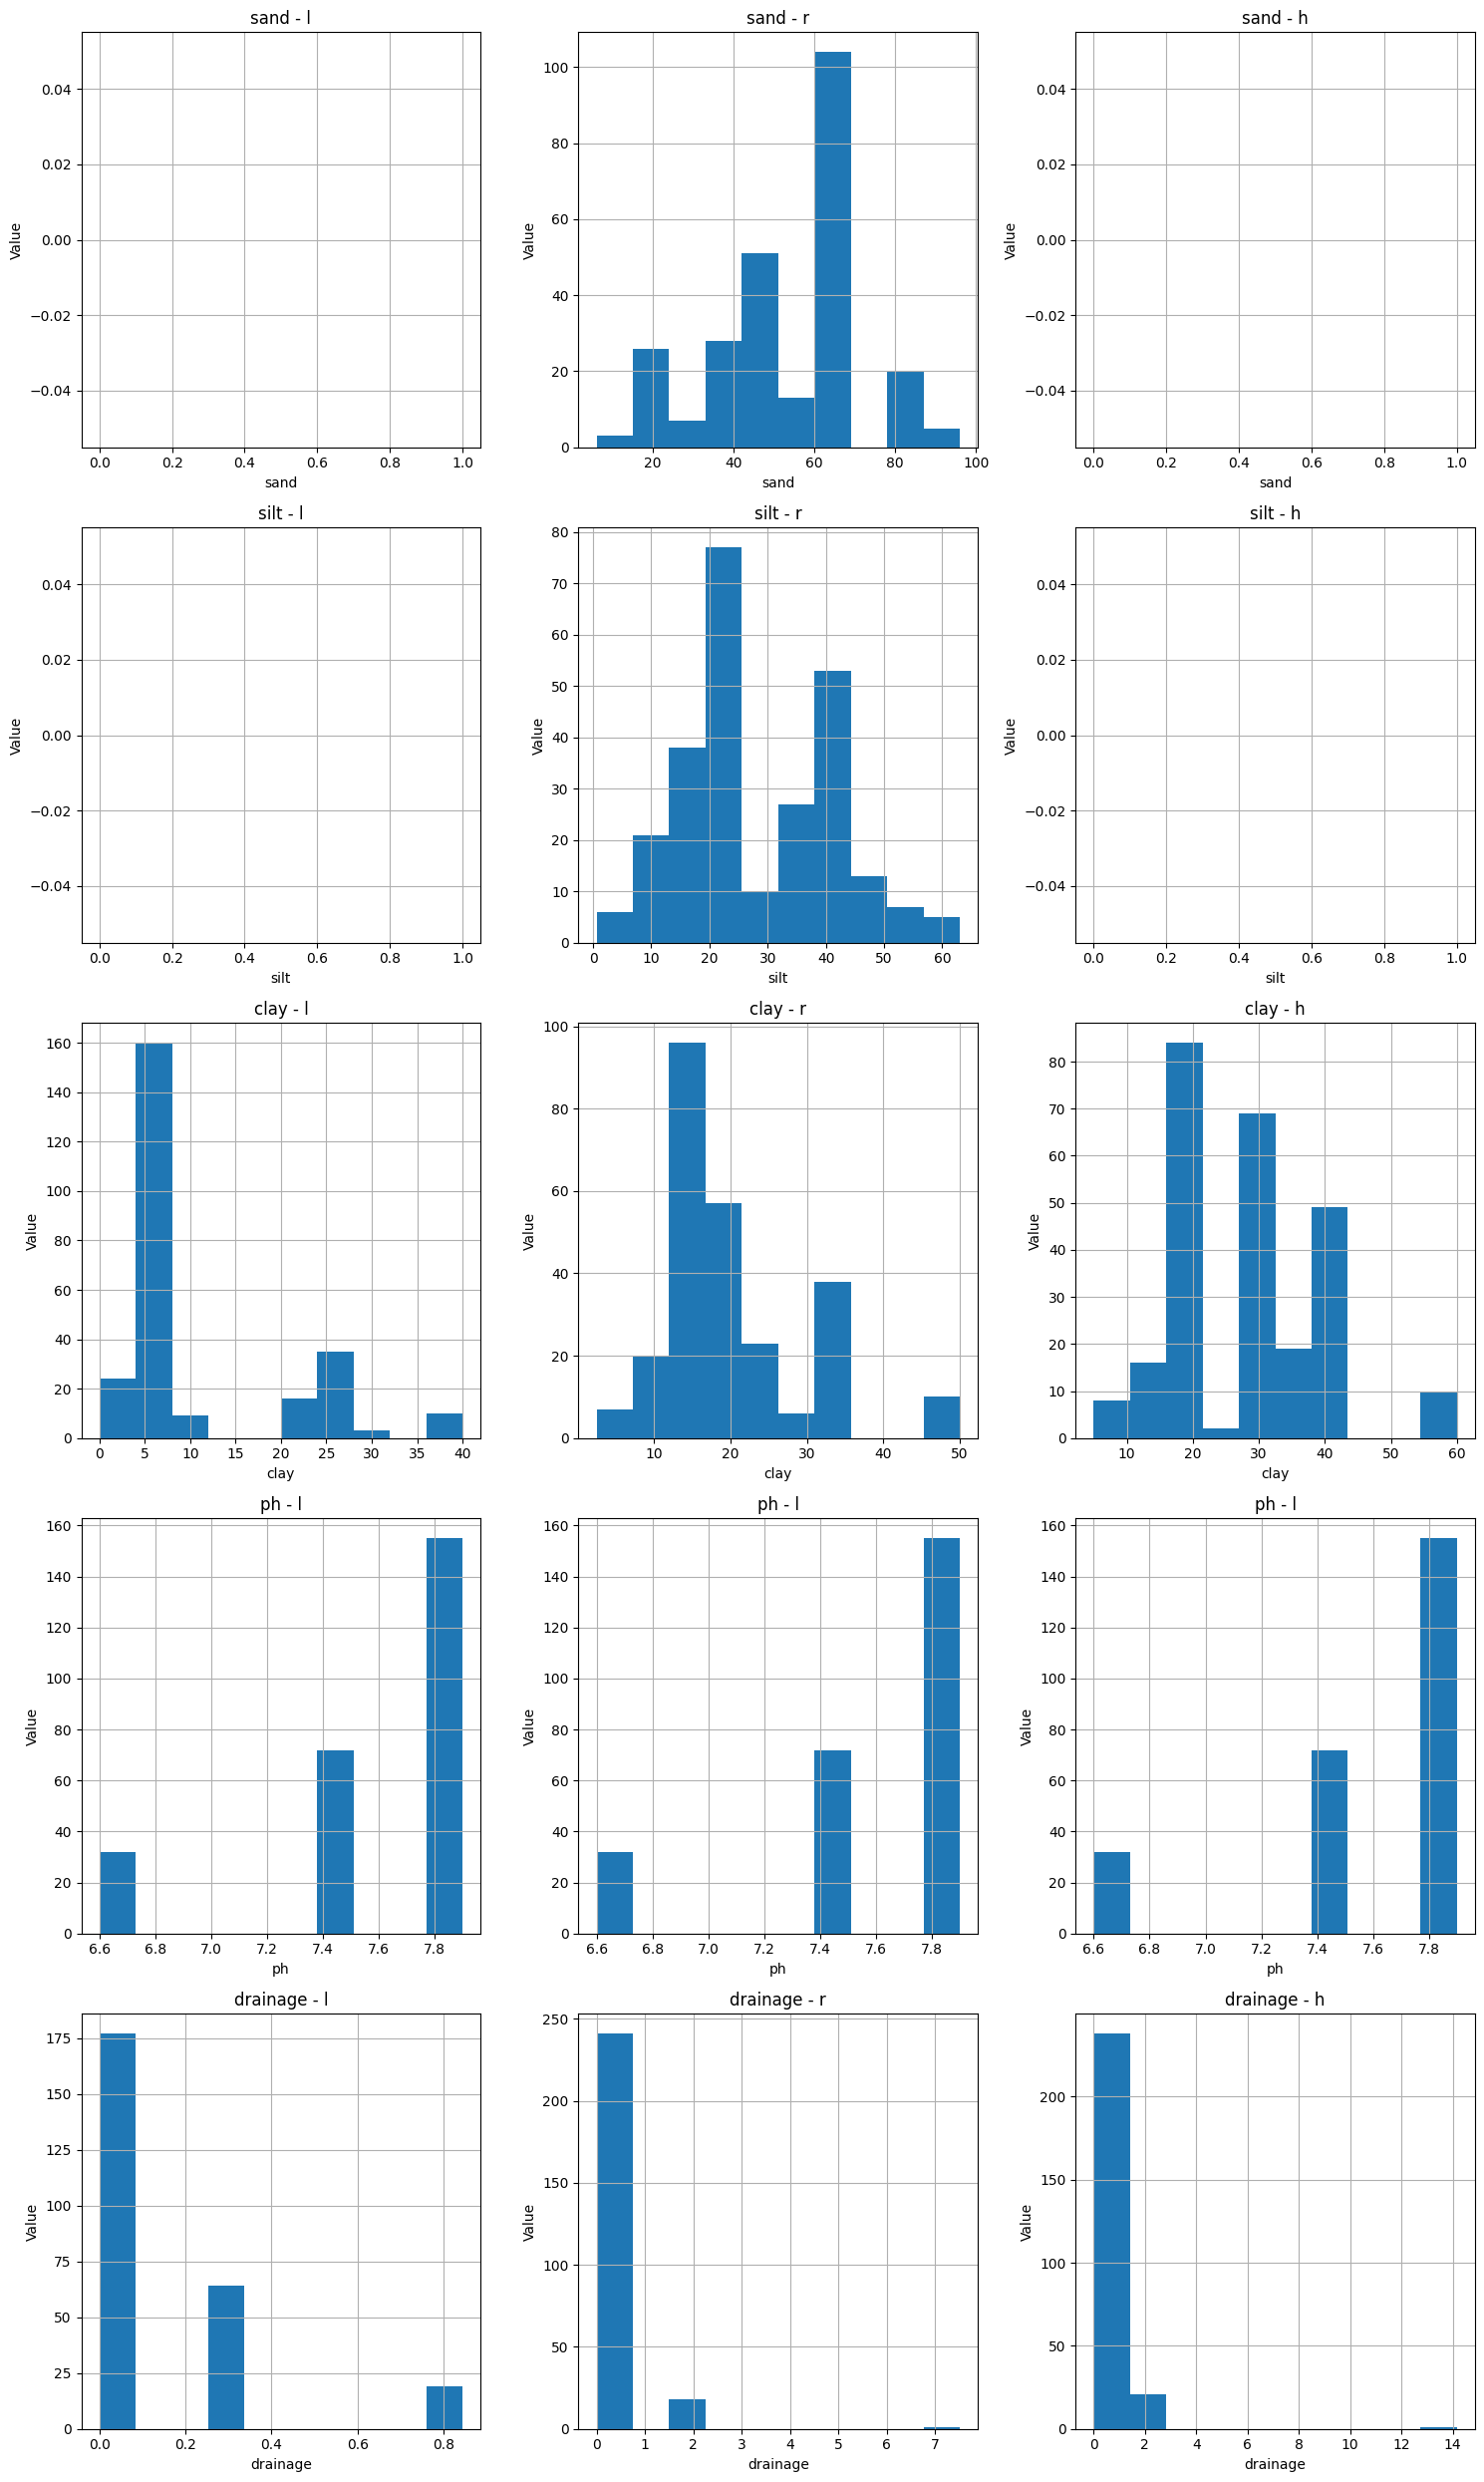

In [236]:
plot_stats(chorizon_df)

In [211]:
matched_df = match_soil_conditions(
    chorizon_df,
    sand_high=target_conditions["sand"][0],
    sand_low=target_conditions["sand"][1],
    # silt_high=target_conditions["silt"][0],
    # silt_low=target_conditions["silt"][1],
    # clay_high=target_conditions["clay"][0],
    # clay_low=target_conditions["clay"][1],
    # ph_high=target_conditions["ph"][0],
    # ph_low=target_conditions["ph"][1],
    # drainage_high=target_conditions["drainage"][0],
    # drainage_low=target_conditions["drainage"][1],
)

In [213]:
target_column_names =[
    "areaname",
    "areasymbol",
    "hzdepb_r",
    "sandtotal_l",
    "sandtotal_r",
    "sandtotal_h",
    "silttotal_l",
    "silttotal_r",
    "silttotal_h",
    "claytotal_l",
    "claytotal_r",
    "claytotal_h",
    "ph1to1h2o_l",
    "ph1to1h2o_r",
    "ph1to1h2o_h",
    "ksat_l",
    "ksat_r",
    "ksat_h"
]
matched_df[target_column_names]

,areaname,areasymbol,hzdepb_r,sandtotal_l,sandtotal_r,sandtotal_h,silttotal_l,silttotal_r,silttotal_h,claytotal_l,claytotal_r,claytotal_h,ph1to1h2o_l,ph1to1h2o_r,ph1to1h2o_h,ksat_l,ksat_r,ksat_h
0,"Navajo County Area, Arizona, Central Part",AZ633,8,55.1,55.1,55.1,17.4,17.4,17.4,20.0,27.5,35.0,7.9,8.5,9.0,0.198425,0.425197,0.566929
1,"Navajo County Area, Arizona, Central Part",AZ633,41,55.1,55.1,55.1,17.4,17.4,17.4,20.0,27.5,35.0,7.9,8.5,9.0,0.198425,0.425197,0.566929
2,"Navajo County Area, Arizona, Central Part",AZ633,152,55.1,55.1,55.1,17.4,17.4,17.4,20.0,27.5,35.0,8.5,8.8,9.0,0.198425,0.425197,0.566929
3,"Navajo County Area, Arizona, Central Part",AZ633,104,55.1,55.1,55.1,17.4,17.4,17.4,20.0,27.5,35.0,8.5,8.8,9.0,0.198425,0.425197,0.566929
6,"Navajo County Area, Arizona, Central Part",AZ633,137,55.1,55.1,55.1,17.4,17.4,17.4,20.0,27.5,35.0,8.5,8.8,9.0,0.566929,1.275591,1.984252
10,"Navajo County Area, Arizona, Central Part",AZ633,152,55.1,55.1,55.1,17.4,17.4,17.4,20.0,27.5,35.0,8.5,8.8,9.0,0.198425,0.425197,0.566929
11,"Navajo County Area, Arizona, Central Part",AZ633,8,55.1,55.1,55.1,17.4,17.4,17.4,20.0,27.5,35.0,7.9,8.5,9.0,0.198425,0.425197,0.566929
12,"Navajo County Area, Arizona, Central Part",AZ633,41,55.1,55.1,55.1,17.4,17.4,17.4,20.0,27.5,35.0,7.9,8.5,9.0,0.198425,0.425197,0.566929
13,"Navajo County Area, Arizona, Central Part",AZ633,104,55.1,55.1,55.1,17.4,17.4,17.4,20.0,27.5,35.0,8.5,8.8,9.0,0.198425,0.425197,0.566929
44,"Navajo County Area, Arizona, Central Part",AZ633,152,62.6,62.6,62.6,14.4,14.4,14.4,16.0,23.0,30.0,7.9,8.5,9.0,0.566929,1.275591,1.984252


Join all data in folders

In [248]:
combined_df = None
for symbol in area_symbols:
    print(f"Processing area with symbol {symbol}", end="...")
    area_fp = pathlib.Path(base_dir).joinpath(symbol).joinpath("tabular").joinpath(area_db_filename)
    area_df = load_area_db(area_fp, area_column_names)

    chorizon_fp = pathlib.Path(base_dir).joinpath(symbol).joinpath("tabular").joinpath(chorizon_db_filename)
    chorizon_df = load_chorizon_db(
        chorizon_fp,
        areaname=area_df.loc[0].areaname,
        areasymbol=area_df.loc[0].areasymbol,
        column_names=chorizon_column_names
    )
    if len(chorizon_df) < 1:
        print(f"Skipping {symbol} as no data", end="\n")
        continue
    
    print(f"Found {len(chorizon_df)} rows", end="\n")
    chorizon_df = chorizon_df[target_column_names]
    if combined_df is None:
        combined_df = chorizon_df
    else:
        combined_df = pd.concat([combined_df, chorizon_df])

Processing area with symbol AZ633...Found 259 rows
Processing area with symbol AZ658...Found 164 rows
Processing area with symbol AZ693...Found 176 rows
Processing area with symbol AZ667...Found 351 rows
Processing area with symbol AZ669...Found 461 rows
Processing area with symbol AZ656...Found 163 rows
Processing area with symbol AZ651...Found 552 rows
Processing area with symbol AZ635...Found 422 rows
Processing area with symbol AZ668...Found 260 rows
Found 849 rowsa with symbol AZ657...
Processing area with symbol AZ695...Found 843 rows
Processing area with symbol AZ661...Found 672 rows
Processing area with symbol AZ659...Found 167 rows
Processing area with symbol AZ666...Found 628 rows
Processing area with symbol AZ714...Found 158 rows
Processing area with symbol NM717...Found 2089 rows
Processing area with symbol AZ713...Found 574 rows
Processing area with symbol AZ723...Skipping AZ723 as no data
Found 257 rowsa with symbol UT689...
Processing area with symbol AZ712...Found 141 r

In [249]:
combined_df.areaname.unique()

array(['Navajo County Area, Arizona, Central Part',
       'Gila River Indian Reservation, Arizona, Parts of Maricopa and Pinal Counties',
       'Oak Creek-San Francisco Peaks Area, Arizona, Part of Coconino County',
       'Santa Cruz and Parts of Cochise and Pima Counties, Arizona',
       'Pima County, Arizona, Eastern Part',
       'Colorado River Indian Reservation, Parts of La Paz County, Arizona, and Riverside and San Bernardino Counties, California',
       'Maricopa County, Arizona, Central Part',
       'Apache County, Arizona, Central Part',
       'Tucson-Avra Valley Area, Arizona',
       'Kofa Area, Arizona, Parts of La Paz and Yuma Counties',
       'Kaibab National Forests, Arizona, Parts of Coconino, Mohave and Yavapai Counties',
       'Eastern Pinal and Southern Gila Counties, Arizona',
       'Pinal County, Arizona, Western Part',
       'Cochise County, Arizona, Northwestern Part',
       'Hopi Area, Arizona, Parts of Coconino and Navajo Counties',
       'Shiproc

In [250]:
combined_df.shape

(24441, 18)

In [251]:
combined_df.to_csv("./datasets/arizona/soil_data.csv", index=False)

In [267]:
target_conditions

{'sand': (65, 55),
 'silt': (33, 27),
 'clay': (11, 9),
 'ph': (7.5, 6.5),
 'drainage': (3, 1)}

In [275]:
matched_df = match_soil_conditions(
    combined_df,
    # sand_high=target_conditions["sand"][0],
    # sand_low=target_conditions["sand"][1],
    # silt_high=target_conditions["silt"][0],
    # silt_low=target_conditions["silt"][1],
    # clay_high=target_conditions["clay"][0],
    # clay_low=target_conditions["clay"][1],
    ph_high=target_conditions["ph"][0],
    ph_low=target_conditions["ph"][1],
    # drainage_high=target_conditions["drainage"][0],
    # drainage_low=target_conditions["drainage"][1],
)
matched_df

,areaname,areasymbol,hzdepb_r,sandtotal_l,sandtotal_r,sandtotal_h,silttotal_l,silttotal_r,silttotal_h,claytotal_l,claytotal_r,claytotal_h,ph1to1h2o_l,ph1to1h2o_r,ph1to1h2o_h,ksat_l,ksat_r,ksat_h
11,"Oak Creek-San Francisco Peaks Area, Arizona, P...",AZ693,97,61.4,61.4,61.4,18.6,18.6,18.6,20.0,20.0,25.0,6.6,7.0,7.3,0.566929,1.275591,1.984252
13,"Oak Creek-San Francisco Peaks Area, Arizona, P...",AZ693,152,77.9,77.9,77.9,16.1,16.1,16.1,5.0,6.0,8.0,6.6,7.0,7.3,1.984252,3.968504,5.952756
15,"Oak Creek-San Francisco Peaks Area, Arizona, P...",AZ693,152,77.9,77.9,77.9,16.1,16.1,16.1,5.0,6.0,8.0,6.6,7.0,7.3,1.984252,3.968504,5.952756
17,"Oak Creek-San Francisco Peaks Area, Arizona, P...",AZ693,97,61.4,61.4,61.4,18.6,18.6,18.6,20.0,20.0,25.0,6.6,7.0,7.3,0.566929,1.275591,1.984252
21,"Oak Creek-San Francisco Peaks Area, Arizona, P...",AZ693,152,77.9,77.9,77.9,16.1,16.1,16.1,5.0,6.0,8.0,6.6,7.0,7.3,1.984252,3.968504,5.952756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,"Beaver Creek Area, Arizona",AZ641,43,22.1,22.1,22.1,27.9,27.9,27.9,35.0,50.0,60.0,6.6,6.8,7.3,0.059528,0.127559,0.198425
111,"Beaver Creek Area, Arizona",AZ641,20,22.1,22.1,22.1,27.9,27.9,27.9,35.0,50.0,60.0,6.6,6.6,7.3,0.059528,0.127559,0.198425
264,"Beaver Creek Area, Arizona",AZ641,25,33.3,33.3,33.3,31.7,31.7,31.7,35.0,35.0,60.0,6.6,6.6,7.3,0.059528,0.127559,0.198425
265,"Beaver Creek Area, Arizona",AZ641,50,22.1,22.1,22.1,27.9,27.9,27.9,35.0,50.0,60.0,6.6,6.8,7.3,0.059528,0.127559,0.198425
